<a href="https://colab.research.google.com/github/kai-v/BayerPatternInterpolation/blob/master/demosiacing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mp
import PIL as pl
import cv2

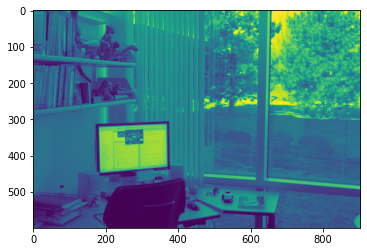

In [ ]:
image_path = "/media/officeBayer.png"
f1 = mp.imread(image_path)
%matplotlib inline
plt.imshow(f1)
# 2. 
#f2.show()
rows,cols = f1.shape

Image Dimentions

In [ ]:
np_img = np.array(f1)
print(np_img.shape)

(600, 903)


Bilinear Interpolation 

In [ ]:
#Numy arrays for R,G,B channels 
Red = np.zeros([rows,cols])
Blue = np.zeros([rows,cols])
Green = np.zeros([rows,cols])

Getting the individual R,B,G channels , leveraging the BGGR pattern 

In [ ]:

for i in range(rows):
  for j in range(cols):
    
    #odd index
    if (i%2 == 1 and j%2 == 1):
     Red[i,j] = np_img[i,j]
     
     #Even index
    elif (i%2 == 0 and j%2 == 0):
     Blue[i,j] = np_img[i,j]
   
    else:
     Green[i,j] = np_img[i,j]
    

Since we know the missing pixel locations , due to the BGGR pattern , we will leverage that and calculate the missing values by taking the average of the values of a particular pixel. 




In [ ]:
Green_interpolated = np.copy(Green)
Red_interpolated = np.copy(Red)
Blue_interpolated = np.copy(Blue)
Green_gradient_interpolated = np.copy(Green)
Red_gradient_interpolated = np.copy(Red)
Blue_gradient_interpolated = np.copy(Blue)

#Zero padding 
Red = np.pad(Red,((2,2),(2,2)),mode='constant') 
Blue = np.pad(Blue,((2,2),(2,2)),mode='constant')
Green = np.pad(Green,((2,2),(2,2)),mode='constant')

#GREEN
for i in range(rows):
  for j in range(cols):
    #Green thats in either a red or blue location
    if((i%2 == 0 and j%2 == 0) or (i%2 == 1 and j%2 == 1)):
     Green_interpolated[i,j] = (1/4)*(Green[i,j-1] + Green[i,j+1] + Green[i - 1,j] + Green[i + 1,j])
     
#RED 
for i in range(rows):
  for j in range(cols):

    #In a green location
    if(i%2 == 1 and j%2 == 0):
      Red_interpolated[i,j] = (1/2)*(Red[i + 1,j] + Red[i - 1,j])

    #In a green location: Blue row , red column
    elif(i%2 == 0 and j%2 == 1):
      Red_interpolated[i,j] = (1/2)*(Blue[i,j-1] + Blue[i,j+1])
      
    #In a blue location: Red row , blue column 
    elif(i%2 == 0 and j%2 == 0):
      Red_interpolated[i,j] = (1/4)*(Red[i + 1,j + 1] + Red[i - 1,j - 1] + Red[i - 1,j + 1] + Red[i + 1,j - 1])
     
 #BLUE 
for i in range(rows):
  for j in range(cols):

    #In a green location: Blue row , red column 
    if(i%2 == 0 and j%2 == 1):
      Blue_interpolated[i,j] = (1/2)*(Blue[i,j-1] + Blue[i,j+1])

    #In a green location: Red row , blue column
    elif(i%2 == 1 and j%2 == 0):
      Blue_interpolated[i,j] = (1/2)*(Blue[i+1,j] + Blue[i - 1,j])

    #In a red location
    elif(i%2 == 1 and j%2 == 1):
      Blue_interpolated[i,j] = (1/4)*(Blue[i + 1,j + 1] + Blue[i - 1,j - 1] + Blue[i - 1,j + 1] + Blue[i + 1,j - 1])

     

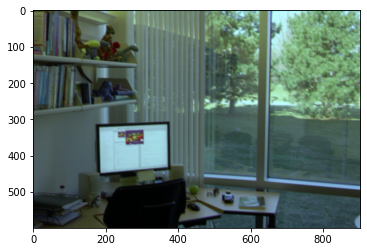

In [ ]:
#Stack the R,G,B channels on to of each other 
final_Image = np.dstack([Red_interpolated,Green_interpolated,Blue_interpolated])
plt.imshow(final_Image)



Now using the proposed algorithm in the paper

Since we calculated the bilinearly interpolated values above , we only need to find the gradient values 

In [ ]:
alpha = 1/2
beta = 5/8
gamma = 3/4

Delta_R = 0
Delta_B = 0
Delta_G = 0

Green in Red and Blue Locations 

In [ ]:

for i in range(rows):
  for j in range(cols):

   #Green in Red locations
   if(i%2 == 1 and j%2 ==1):
    
     Delta_R = Red[i,j] - (1/4)*(Red[i,j-2] + Red[i,j+2] + Red[i - 2,j] + Red[i + 2,j])
     Green_gradient_interpolated[i,j] = (Green_interpolated[i,j] + alpha*Delta_R)      
     
   #Green in Blue locations 
   if(i%2 == 0 and j%2 == 0):

     Delta_B = Blue[i,j] - (1/4)*(Blue[i,j-2] + Blue[i,j+2] + Blue[i - 2,j] + Blue[i + 2,j])
     Green_gradient_interpolated[i,j] = Green_interpolated[i,j] + gamma*Delta_B
     
    
   if(Green_gradient_interpolated[i,j] < 0):
       Green_gradient_interpolated[i,j] = 0

   if(Green_gradient_interpolated[i,j] > 1):
       Green_gradient_interpolated[i,j] = 1

  
      


Red in Blue and Green locations 

In [ ]:
#Red in blue and green locations 
for i in range(rows):
  for j in range(cols):
    
    #In blue locations
    if (i%2 == 0 and j%2 == 0):
    
     Delta_B = Blue[i,j] - (1/4)*((3/2)*(Blue[i,j-2] + Blue[i,j+2] + Blue[i - 2,j] + Blue[i + 2,j]))
     Red_gradient_interpolated[i,j] = (Red_interpolated[i,j] + gamma*Delta_B)
    
    #In green locations
    
    #In red row , blue column 
    if(i%2 == 1 and j%2 == 0):
      Delta_G = Green[i,j] - (1/8)*(Green[i + 1,j + 1] + Green[i - 1,j - 1] + Green[i - 1,j + 1] + Green[i + 1,j - 1] 
                                    + Green[i,j-2] + Green[i,j+2] - (1/2)*(Green[i+2,j] + Green[i-2,j]))
      
    #In blue row , red column 
    elif(i%2 == 0 and j%2 == 1):
      Delta_G = Green[i,j] - (1/8)*(Green[i + 1,j + 1] + Green[i - 1,j - 1] + Green[i - 1,j + 1] + Green[i + 1,j - 1] 
                                    + Green[i+2,j] + Green[i-2,j] - (1/2)*(Green[i,j-2] + Green[i,j+2]))
    
    Red_gradient_interpolated[i,j] = Red_interpolated[i,j] + beta*Delta_G

    if(Red_gradient_interpolated[i,j] < 0):
     Red_gradient_interpolated[i,j] = 0
        
    if(Red_gradient_interpolated[i,j] > 1):
     Red_gradient_interpolated[i,j] = 1
 

Blue in Green and Red locations

In [ ]:
for i in range(rows):
  for j in range(cols):
    
    #In Red Locations
    if(i%2 == 1 and j%2 == 1):

     Delta_R = Red[i,j] - (1/4)*((3/2)*(Red[i,j-2] + Red[i,j+2] + Red[i - 2,j] + Red[i + 2,j]))
     Blue_gradient_interpolated[i,j] = (Blue_interpolated[i,j] + gamma*Delta_R)

  #In Green Locations
    
  #In red row , blue column 
    if(i%2 == 1 and j%2 == 0):
      Delta_G = Green[i,j] - (1/8)*(Green[i + 1,j + 1] + Green[i - 1,j - 1] + Green[i - 1,j + 1] + Green[i + 1,j - 1] 
                                    + Green[i,j-2] + Green[i,j+2] - (1/2)*(Green[i+2,j] + Green[i-2,j]))
     
  #In blue row , red column 
    elif(i%2 == 0 and j%2 == 1):
      Delta_G = Green[i,j] - (1/8)*(Green[i + 1,j + 1] + Green[i - 1,j - 1] + Green[i - 1,j + 1] + Green[i + 1,j - 1] 
                                    + Green[i+2,j] + Green[i-2,j] - (1/2)*( Green[i,j-2] + Green[i,j+2]))
      
    Blue_gradient_interpolated[i,j] = (Blue_interpolated[i,j] + beta*Delta_G)

    if(Blue_gradient_interpolated[i,j] < 0):
       Blue_gradient_interpolated[i,j] = 0

    if(Blue_gradient_interpolated[i,j] > 1):
       Blue_gradient_interpolated[i,j] = 1


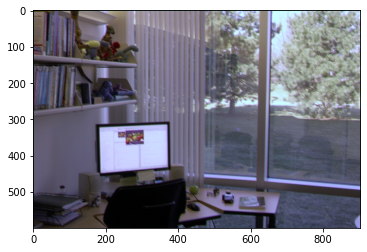

In [ ]:
final_gradient_Image = np.dstack([Red_gradient_interpolated,Green_gradient_interpolated, Blue_gradient_interpolated])
plt.imshow(final_gradient_Image)

(600, 903, 3)


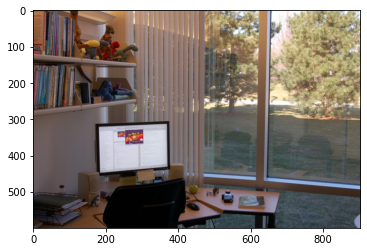

In [ ]:

original_image_path = "/media/office_4.jpg"
original = mp.imread(original_image_path)
plt.imshow(original)

Calculating MSE values 

In [1]:
MSE1 = 0 #First Algorithm
MSE2 = 0 #Second Algorithm

MSE1 = np.sum((original.astype("float") - final_Image.astype("float")) ** 2) #Sum
MSE1 /= float(original.shape[0] * final_Image.shape[1]) #Divide by size 

MSE2 = np.sum((original.astype("float") - final_gradient_Image.astype("float")) ** 2) #Sum
MSE2 /= float(original.shape[0] * final_gradient_Image.shape[1]) #Divide by size 



NameError: ignored